In [5]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import joblib


In [6]:
# Load the dataset
df = pd.read_csv('/content/Crop_recommendation.csv')  # Make sure name matches
df.head()


,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [7]:
# 1. Structure and basic summary
df.info()
df.describe()

# 2. Null values?
print("Missing values:\n", df.isnull().sum())

# 3. Duplicates?
print("Duplicates:", df.duplicated().sum())
df = df.drop_duplicates()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2200 entries, 0 to 2199
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   N            2200 non-null   int64  
 1   P            2200 non-null   int64  
 2   K            2200 non-null   int64  
 3   temperature  2200 non-null   float64
 4   humidity     2200 non-null   float64
 5   ph           2200 non-null   float64
 6   rainfall     2200 non-null   float64
 7   label        2200 non-null   object 
dtypes: float64(4), int64(3), object(1)
memory usage: 137.6+ KB
Missing values:
 N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64
Duplicates: 0


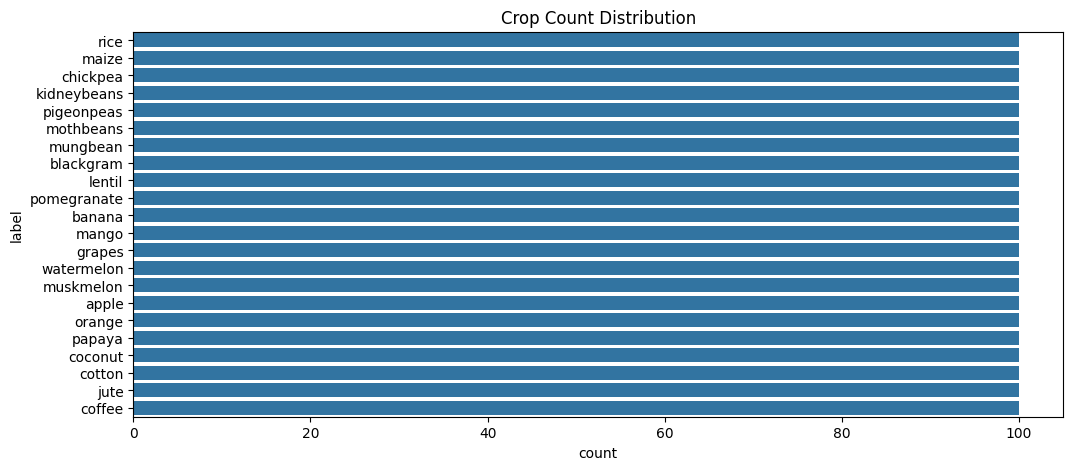

In [8]:
# Plot distribution of target (crops)
plt.figure(figsize=(12,5))
sns.countplot(data=df, y='label', order=df['label'].value_counts().index)
plt.title('Crop Count Distribution')
plt.show()


In [9]:
# Input and output separation
X = df.drop('label', axis=1)
y = df['label']

# Encode labels into numbers
le = LabelEncoder()
y_encoded = le.fit_transform(y)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)


In [11]:
# Random Forest works great here
clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

In [12]:
y_pred = clf.predict(X_test)

print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


✅ Accuracy: 0.9931818181818182

📊 Classification Report:
               precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      1.00      1.00        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       1.00      1.00      1.00        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.92      1.00      0.96        23
 kidneybeans       1.00      1.00      1.00        20
      lentil       0.92      1.00      0.96        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.96      0.98        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00

In [13]:
joblib.dump(clf, 'crop_model.pkl')
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

In [14]:
# Example: test with random values
sample = np.array([[90, 42, 43, 20.5, 80.0, 6.5, 120.0]])  # Replace with user inputs
prediction = clf.predict(sample)
predicted_crop = le.inverse_transform(prediction)
print("🌾 Suggested Crop:", predicted_crop[0])


🌾 Suggested Crop: rice


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [21]:
sample = np.array([[30,40,60,55,0,10,11]])
prediction = clf.predict(sample)
predicted_crop = le.inverse_transform(prediction)
print("Predicted Crop:", predicted_crop[0])

Predicted Crop: muskmelon


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [15]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


In [16]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


In [17]:
rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,              # 5-fold cross-validation
                           scoring='accuracy',
                           n_jobs=-1,         # Use all cores
                           verbose=2)


In [18]:
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy', verbose=2)

In [19]:
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

# Get the best model
best_model = grid_search.best_estimator_

# Test performance
from sklearn.metrics import accuracy_score
y_pred = best_model.predict(X_test)
print("Test Accuracy:", accuracy_score(y_test, y_pred))


Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 150}
Best Cross-Validated Accuracy: 0.9954545454545455
Test Accuracy: 0.9931818181818182
